In [1]:
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# local
from utils import *
sys.path.append("../imaging-utils")
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_05_11")

In [4]:
vel_data = {
    depth: {
        int(vel): np.stack(
            [
                io.imread(os.path.join(data_path, depth, vel, f))
                for f in os.listdir(os.path.join(data_path, depth, vel))
                if (f.endswith(".tiff") or f.endswith(".tif"))
            ],
            axis=0
        )
        for vel in os.listdir(os.path.join(data_path, depth))
        if (os.path.isdir(os.path.join(data_path, depth, vel)) and vel.isnumeric())        
    }
    for depth in ["DD", "PD"]
}

n_trials, n_frames, y_sz, x_sz = vel_data["DD"][300].shape
dt = 1 / 565
recs_xaxis = np.arange(n_frames) * dt
velocities = np.array(list(sorted(vel_data["DD"].keys())))
print("velocity stack shape:", vel_data["DD"][300].shape)

velocity stack shape: (2, 4500, 12, 512)


<IPython.core.display.Javascript object>


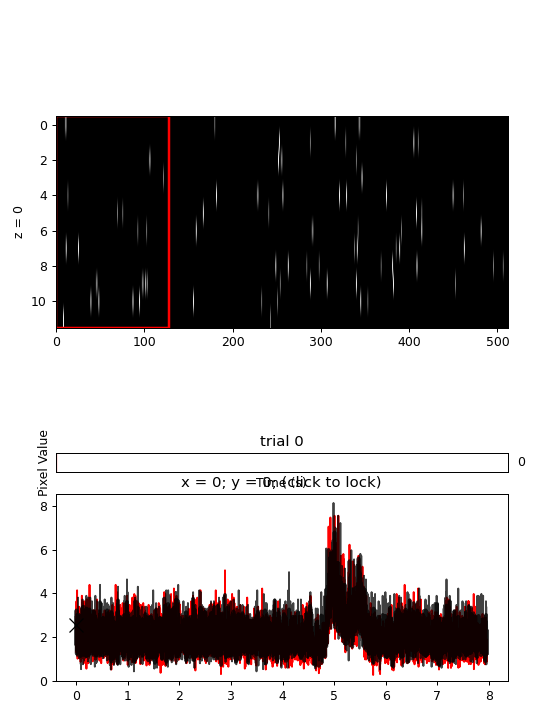

In [5]:
stack_plot = StackExplorer(
    vel_data["DD"][300],
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(128, 12),
    vmin=0,
    figsize=(6, 8)
)
stack_plot.ax[0].set_aspect(20)
stack_plot.ax[1].set_xlabel("Time (s)")
stack_plot.ax[1].set_ylabel("Pixel Value")
stack_plot.fig.show()

### Grid ROI placement using Quality Index acceptance threshold
Take `grid_w` by `grid_h` beams from the scan field and discard those that do not meet the `min_qi` threshold.

In [6]:
grid_w = 128
grid_h = 12

def aligned_avg(avg_recs):
    filtered = np.stack([savgol_filter(r, 71, 3) for r in avg_recs], axis=0)
    max_idxs = np.argmax(filtered, axis=1)
    shifts = max_idxs - np.min(max_idxs)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned
    
grid_recs, avg_grid_recs, aligned_grid_avg, grid_locs = {}, {}, {}, {}
for depth, vels in vel_data.items():
    grid_recs[depth], avg_grid_recs[depth], grid_locs[depth], = {}, {}, {}
    aligned_grid_avg[depth] = {}
    for v, stack in vels.items():
        recs, locs = [], []
        for x0 in range(0, x_sz, grid_w):
            for y0 in range(0, y_sz, grid_h):
                beams = np.mean(stack[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
                recs.append(beams)
                locs.append([x0, y0])        
        grid_recs[depth][v] = np.stack(recs, axis=1)
        avg_grid_recs[depth][v] = np.mean(grid_recs[depth][v], axis=0)
        grid_locs[depth][v] = np.stack(locs, axis=0)
        aligned_grid_avg[depth][v] = aligned_avg(avg_grid_recs[depth][v])

<IPython.core.display.Javascript object>


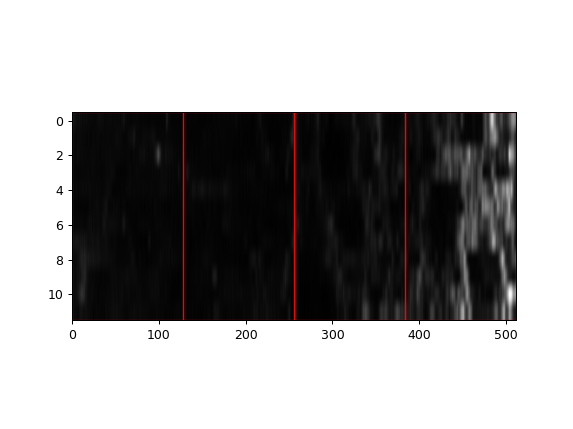

In [7]:
depth = "PD"
vel = 300

mean_stack_proj = np.mean(vel_data[depth][vel], axis=(0,1))

half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(1)

grid_ax.imshow(mean_stack_proj, cmap="gray", aspect=20)
for (x, y) in grid_locs[depth][vel]:
    grid_ax.add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

<IPython.core.display.Javascript object>


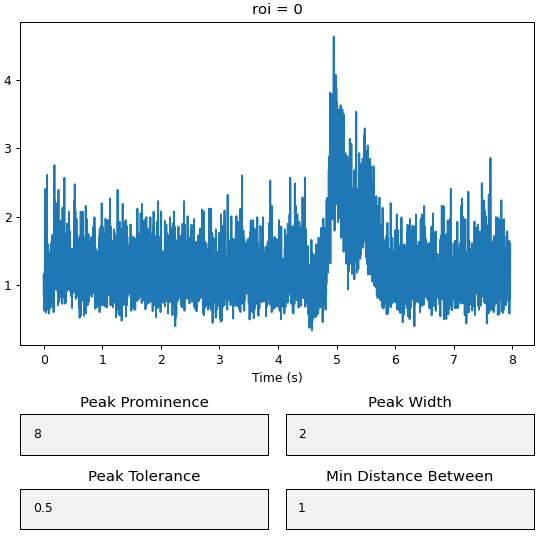

In [8]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
#     grid_recs[depth][vel][0],
    avg_grid_recs[depth][vel],
    prominence=8,
    width=2,
    tolerance=.5,
    distance=1
)

In [9]:
grid_idx = 2
norm_amp_fitting = False

fits, fitted_recs = {}, {}
# for depth, vels in aligned_grid_avg.items():
for depth, vels in avg_grid_recs.items():
    fits[depth], fitted_recs[depth] = {}, {}
    for v, recs in sorted(vels.items()):
#         y = savgol_filter(recs, 91, 3)
        y = savgol_filter(recs[grid_idx], 91, 3)
        i0 = find_rise_bsln(y, step=5)
#         i0 = find_rise_start(y, step=15)
        y_sub = y[i0:] - y[i0]
#         y_sub = recs[i0:] - recs[i0]
        y_norm = y_sub / y_sub.max()
        x_trunc = np.arange(len(y) - i0) * dt
        fitter = BiexpFitter(0.05, 0.055, norm_amp=norm_amp_fitting)
        fitter.fit(x_trunc, y_norm)
        g = fitter.calc_g(x_trunc)
        print(
            "[%s, %i] -> tau1: %.4f; tau2: %.4f" %
            (
                depth,
                v,
                fitter.results.params["tau1"], 
                fitter.results.params["tau2"]
            )
        )
        fits[depth][v] = {"g": g, **fitter.results.params}
        fitted_recs[depth][v] = y_norm

if norm_amp_fitting:
    pack_hdf(os.path.join(data_path, "velocity_tau_fits_normed_peaks"), fits)
else:
    pack_hdf(os.path.join(data_path, "velocity_tau_fits"), fits)    

[DD, 300] -> tau1: 0.0384; tau2: 0.3190
[DD, 500] -> tau1: 0.0305; tau2: 0.2393
[DD, 1000] -> tau1: 0.0190; tau2: 0.1417
[DD, 2000] -> tau1: 0.0178; tau2: 0.1198
[DD, 3000] -> tau1: 0.0147; tau2: 0.0897
[DD, 4000] -> tau1: 0.0159; tau2: 0.1186
[DD, 5000] -> tau1: 0.0188; tau2: 0.1131
[PD, 300] -> tau1: 0.0424; tau2: 0.4316
[PD, 500] -> tau1: 0.0244; tau2: 0.2857
[PD, 1000] -> tau1: 0.0212; tau2: 0.2055
[PD, 2000] -> tau1: 0.0202; tau2: 0.1291
[PD, 3000] -> tau1: 0.0182; tau2: 0.1177
[PD, 4000] -> tau1: 0.0193; tau2: 0.1249
[PD, 5000] -> tau1: 0.0001; tau2: 0.0789


<IPython.core.display.Javascript object>


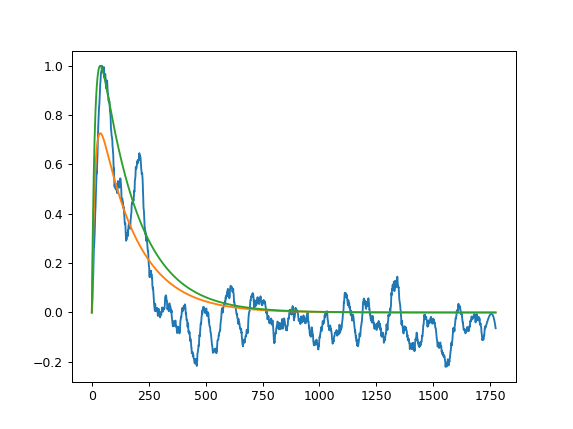

In [10]:
def biexp(x, m, t1, t2, b):
    return m * (np.exp(-t1 * x) - np.exp(-t2 * x)) + b

def mono_exp_decay(x, m, t, b):
    return m * np.exp(-t * x) + b

depth = "PD"
vel = 500

x = np.arange(len(fitted_recs[depth][vel])) * dt
manual1 = biexp(x, 4., 5.65, 11.61, 0)
bi = biexp(x, 1., fits[depth][vel]["tau1"] * 100, fits[depth][vel]["tau2"] * 100, 0)
manual2 = mono_exp_decay(x, 1, 0.1, 0) - mono_exp_decay(x, 1, 0.01, 0)
dummy = BiexpFitter(0.057, .116, norm_amp=True)
manual3 = dummy.model(t=x, tau1=0.05, tau2=0.055, y0=1.)[0]

ff, aa = plt.subplots(1)
aa.plot(fitted_recs[depth][vel])
aa.plot(fits[depth][vel]["g"])
aa.plot(fits[depth][vel]["g"] / np.max(fits[depth][vel]["g"]))
# aa.plot(bi / np.max(bi))
# aa.plot(manual2)
# aa.plot(manual3)

<IPython.core.display.Javascript object>


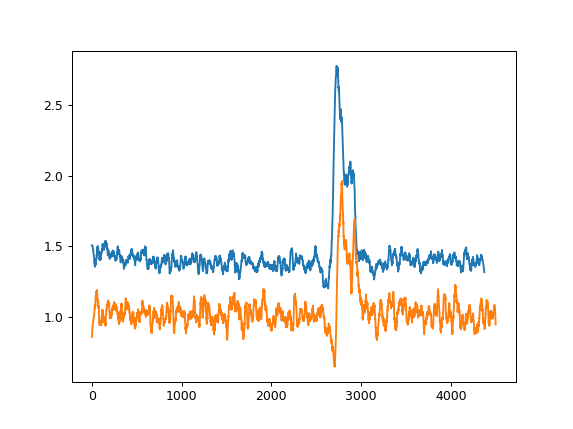

In [11]:
ff1, aa1 = plt.subplots(1)
aa1.plot(savgol_filter(aligned_grid_avg[depth][vel], 51, 3))
aa1.plot(savgol_filter(avg_grid_recs[depth][vel][grid_idx], 51, 3))

<IPython.core.display.Javascript object>


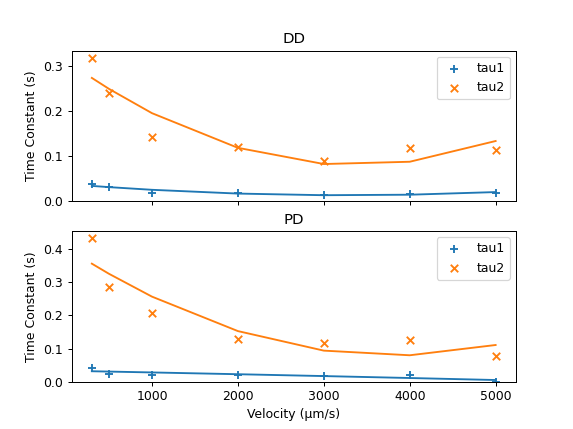

In [12]:
tune_fig, tune_ax = plt.subplots(2, sharex=True)
for ax, (depth, vels) in zip(tune_ax, fits.items()):
    tau1 = [vels[v]["tau1"] for v in velocities]
    tau2 = [vels[v]["tau2"] for v in velocities]
    t1_coefs = np.polyfit(velocities, tau1, deg=2)
    t2_coefs = np.polyfit(velocities, tau2, deg=2)
    ax.scatter(velocities, tau1, marker="+", label="tau1")
    ax.scatter(velocities, tau2, marker="x", label="tau2")
    ax.plot(velocities, np.poly1d(t1_coefs)(velocities))
    ax.plot(velocities, np.poly1d(t2_coefs)(velocities))
    ax.set_title(depth)

for a in tune_ax:
    a.set_ylabel("Time Constant (s)")
    a.set_ylim(0)
    a.legend()
    
tune_ax[0].set_title("DD")
tune_ax[1].set_xlabel("Velocity (μm/s)")
tune_fig.show()

In [13]:
# import json
# import h5py as h5

# base_path = "/mnt/Data/NEURONoutput/sac_sac/"
# model_path = base_path + "model_runs/"
# load_name = "test"

# with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
#     data = unpack_hdf(f)

# exp_params = json.loads(data[0]["control"]["exp_params"])
# exps = {k: v["data"] for k, v in data[0].items()}

In [14]:
# nrn_fig, nrn_ax = plt.subplots(1)
# nrn_xaxis = np.arange(0, exp_params["tstop"] + exp_params["dt"], exp_params["dt"])
# example = exps["control"]["bps"]["a"]["sust"][0]["g"][0][0]
# nrn_ax.plot(nrn_xaxis / 1000 - 1, example / np.max(example))
# nrn_ax.plot(np.arange(len(fits["PD"][300]["g"])) * 565, fits["PD"][300]["g"] / np.max(fits["PD"][300]["g"]) )

<IPython.core.display.Javascript object>


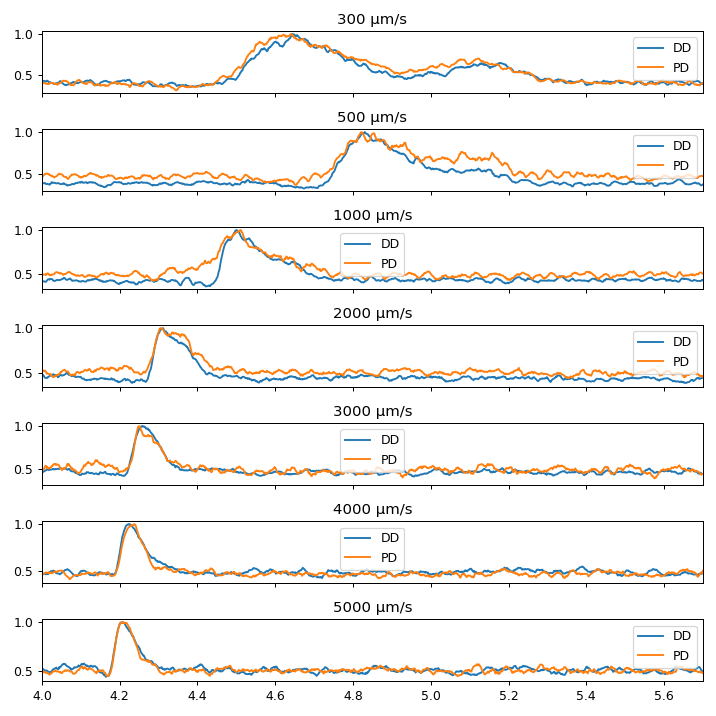

In [15]:
norm = True
depth_comp_fig, depth_comp_ax = plt.subplots(len(velocities), sharex=True, figsize=(8, 8))
for ax, vel in zip(depth_comp_ax, velocities):
#     if vel == 3000:
#         continue
    for depth in vel_data.keys():
        x = np.arange(len(aligned_grid_avg[depth][vel])) * dt
        y = savgol_filter(aligned_grid_avg[depth][vel], 21, 3)

#         x = np.arange(len(avg_grid_recs[depth][vel][grid_idx])) * dt
#         y = savgol_filter(avg_grid_recs[depth][vel][2], 21, 3)
#         y = avg_grid_recs[depth][vel][3]

#         x = np.arange(len(grid_recs[depth][vel][1, grid_idx])) * dt
#         y = savgol_filter(grid_recs[depth][vel][1, 2], 21, 3)
        if norm:
            y /= y.max()
        ax.plot(x, y, label=depth)
        ax.set_title("%i μm/s" % vel)
        ax.legend()
        ax.set_xlim(4, 5.7)
        
depth_comp_fig.tight_layout()


### Prerna Waveforms, first N (2021_05_11)

In [16]:
waveforms = {d: {v: [] for v in velocities} for d in ["DD", "PD"]}
for f in os.listdir(os.path.join(data_path, "waveforms")):
    waves = pd.read_csv(os.path.join(data_path, "waveforms", f), skiprows=1).values.T
    for v, w in zip(velocities, waves):
        if not np.isnan(w).any():
            waveforms[f[:2]][v].append(w)

waveforms = {
    d: {v: np.stack(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms.items()
}

avg_waveforms = {
    d: {v: np.mean(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms.items()
}

<IPython.core.display.Javascript object>


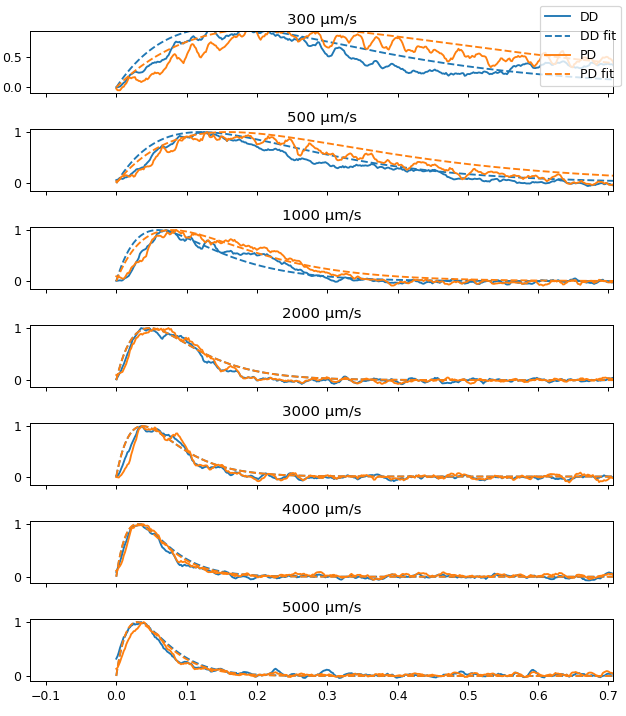

In [17]:
manual_taus = {
    "DD": {
        # TODO: fudged 300 and 500 taus to matche the ppt better
        300: {"tau1": 0.15, "tau2": 0.16},
        500: {"tau1": 0.12, "tau2": 0.120001},
        1000: {"tau1": 0.05, "tau2": 0.07},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.030, "tau2": 0.031},
        5000: {"tau1": 0.03, "tau2": 0.031},
    },
    "PD": {
        # TODO: fudged 300 and 500 taus to matche the ppt better
        300: {"tau1": 0.23, "tau2": 0.24},
        500: {"tau1": 0.15, "tau2": 0.17},
        1000: {"tau1": 0.07, "tau2": 0.09},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.029, "tau2": 0.03},
        5000: {"tau1": 0.029, "tau2": 0.03},
    },
}

dummy = BiexpFitter(0.057, .116, norm_amp=True)

manual_tau_fig, manual_tau_ax = plt.subplots(len(velocities), sharex=True, figsize=(7, 8))
for i, (ax, vel) in enumerate(zip(manual_tau_ax, velocities)):
    for j, depth in enumerate(vel_data.keys()):
        x = np.arange(1.5 / dt) * dt
        fit = dummy.model(
            t=x, 
            tau1=manual_taus[depth][vel]["tau1"],
            tau2=manual_taus[depth][vel]["tau2"],
            y0=1.,
        )[0]
        manual_taus[depth][vel]["g"] = fit
        wave = avg_waveforms[depth][vel] / avg_waveforms[depth][vel].max()
        if depth == "DD":  # use the index from DD
            rise_idx = find_rise_bsln(wave, bsln_start=1000, bsln_end=2000)
        if not i:
            wave_lbl = depth
            fit_lbl = "%s fit" % depth
        else:
            wave_lbl, fit_lbl = None, None
        ax.plot(x, wave[rise_idx:rise_idx + len(x)], c="C%i" % j, label=wave_lbl)
        ax.plot(x, fit, linestyle="--", c="C%i" % j, label=fit_lbl)
        ax.set_title("%i μm/s" % vel)
        
manual_tau_fig.legend()
manual_tau_fig.tight_layout()

pack_hdf(os.path.join(data_path, "manual_tau_fits"), manual_taus)

### Prerna Waveforms, second N (2021_05_12)

In [27]:
data_path_2 = os.path.join(base_path, "2021_05_12")
velocities_2 = np.array([100, 300, 500, 1000, 2000, 3000, 4000, 5000])

waveforms_2 = {d: {v: [] for v in velocities_2} for d in ["DD", "PD"]}
for f in os.listdir(os.path.join(data_path_2, "waveforms")):
    waves = pd.read_csv(os.path.join(data_path_2, "waveforms", f), skiprows=1).values.T
    for v, w in zip(velocities_2, waves):
        if not np.isnan(w).any():
            waveforms_2[f[:2]][v].append(w)

waveforms_2 = {
    d: {v: np.stack(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms_2.items()
}

avg_waveforms_2 = {
    d: {v: np.mean(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms_2.items()
}

<IPython.core.display.Javascript object>


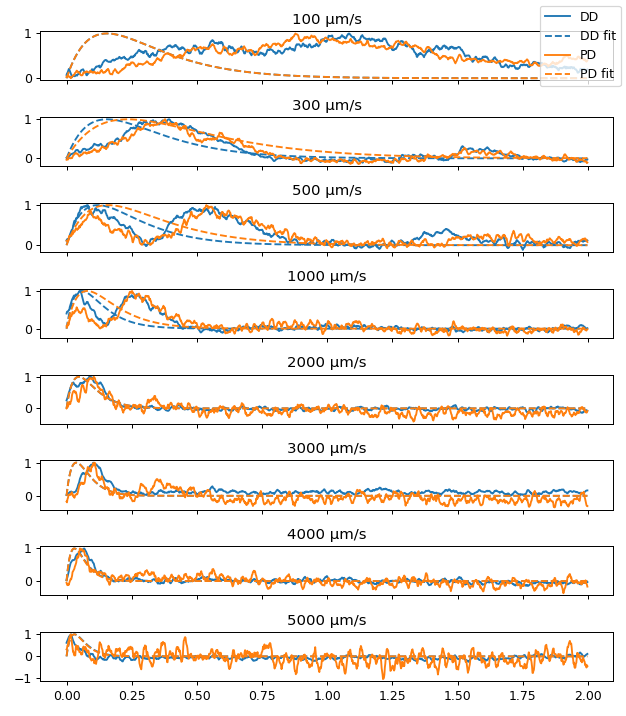

In [28]:
manual_taus_2 = {
    "DD": {
        100: {"tau1": 0.15, "tau2": 0.16},
        300: {"tau1": 0.15, "tau2": 0.16},
        500: {"tau1": 0.12, "tau2": 0.120001},
        1000: {"tau1": 0.05, "tau2": 0.07},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.030, "tau2": 0.031},
        5000: {"tau1": 0.03, "tau2": 0.031},
    },
    "PD": {
        100: {"tau1": 0.15, "tau2": 0.16},
        300: {"tau1": 0.23, "tau2": 0.24},
        500: {"tau1": 0.15, "tau2": 0.17},
        1000: {"tau1": 0.07, "tau2": 0.09},
        2000: {"tau1": 0.045, "tau2": 0.05},
        3000: {"tau1": 0.035, "tau2": 0.04},
        4000: {"tau1": 0.029, "tau2": 0.03},
        5000: {"tau1": 0.029, "tau2": 0.03},
    },
}

dummy = BiexpFitter(0.057, .116, norm_amp=True)

manual_tau_2_fig, manual_tau_2_ax = plt.subplots(
    len(velocities_2), sharex=True, figsize=(7, 8))
for i, (ax, vel) in enumerate(zip(manual_tau_2_ax, velocities_2)):
    for j, depth in enumerate(vel_data.keys()):
        x = np.arange(2.0 / dt) * dt
        fit = dummy.model(
            t=x, 
            tau1=manual_taus_2[depth][vel]["tau1"],
            tau2=manual_taus_2[depth][vel]["tau2"],
            y0=1.,
        )[0]
        manual_taus_2[depth][vel]["g"] = fit
        wave = avg_waveforms_2[depth][vel] / avg_waveforms_2[depth][vel][1000:].max()
        if depth == "DD":  # use the index from DD
            rise_idx = find_rise_bsln(wave, bsln_start=1000, bsln_end=2000)
        if not i:
            wave_lbl = depth
            fit_lbl = "%s fit" % depth
        else:
            wave_lbl, fit_lbl = None, None
        ax.plot(x, wave[rise_idx:rise_idx + len(x)], c="C%i" % j, label=wave_lbl)
        ax.plot(x, fit, linestyle="--", c="C%i" % j, label=fit_lbl)
        ax.set_title("%i μm/s" % vel)
        
manual_tau_2_fig.legend()
manual_tau_2_fig.tight_layout()

pack_hdf(os.path.join(data_path_2, "manual_tau_fits"), manual_taus_2)

<IPython.core.display.Javascript object>


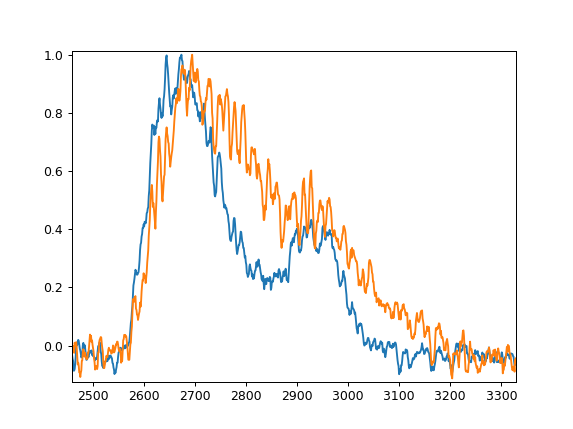

In [34]:
ff, aa = plt.subplots(1)
aa.plot(avg_waveforms["DD"][300] / avg_waveforms["DD"][300].max())
aa.plot(avg_waveforms["PD"][300] / avg_waveforms["PD"][300].max())